# Projet AAS — Accidents corporels 2019 



## Plan
1. Étape 1 - Compréhension du dataset  
2. Étape 2 - Nettoyage / Data Cleaning 
3. Étape 3 - Analyse Exploratoire (EDA)  
4. Étape 4 - Préparation et séparation (X/y + encodage simple + split)
5. Étape 5 - Construction d'un modèle de ML
6. Étape 6 - Évaluation du modèle (Accuracy,  F1-Score , Matrice de confusion)
7. Étape 7 - Interprétation des résultats 

**Tâche supervisée** : classification — cible **`grav`** (gravité des blessures).


In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)


# Étape 1 — Compréhension du jeu de données

**Origine** : data.gouv.fr — BAAC (Accidents corporels de la circulation)  
**Année** : 2019  

## Tables
- `caracteristiques-2019.csv` : infos générales sur l’accident (date/heure, conditions…)
- `lieux-2019.csv` : infos sur le lieu (route, infrastructure…)
- `vehicules-2019.csv` : infos véhicules
- `usagers-2019.csv` : infos usagers (dont la cible `grav`)

## Objectif
Prédire **`grav`** (gravité) à partir des variables explicatives issues des tables.

## Définition de la tâche

Pour ce projet, la tâche la plus pertinente et la plus classique est la Classification.

Tâche principale (Classification) : Prédire la gravité de l'accident pour un usager donné.

Variable cible (Target) : grav (dans la table usagers).

Classes : 1 (Indemne), 2 (Tué), 3 (Blessé hospitalisé), 4 (Blessé léger). 

        
## Description détaillée des 4 fichiers
A. `caracteristiques-2019.csv` (Le contexte "Quand et Où")  
Ce fichier contient les métadonnées générales de l'accident. Il y a une ligne par accident.  
    Identifiant : Num_Acc.  
    Variables clés :  
        Temporelles : jour, mois, hrmn (heure/minute).  
        Géographiques : dep (département), com (commune), lat, long (coordonnées GPS pour la cartographie).  
        Conditions : lum (luminosité : nuit/jour), atm (conditions atmosphériques : pluie/neige), col (type de collision). 
        Agglomération : si l'accident s'est déroulé en agglomération ou pas.

B. `lieux-2019.csv` (L'infrastructure "Sur quoi")

Ce fichier décrit la route et l'environnement au moment de l'accident. Il y a généralement une ligne par accident (liée à caracteristiques).

    Identifiant : Num_Acc.

    Variables clés :

        Route : catr (catégorie de route : autoroute, nationale...), vma (vitesse maximale autorisée), nbv (nombre de voies).

        État : surf (état de la surface : mouillée, verglacée), circ (regime de circulation).

        Infrastructure : infra (aménagement : tunnel, pont, carrefour).

C. `vehicules-2019.csv` (Les véhicules impliqués)

Ce fichier recense tous les véhicules motorisés impliqués.

    Identifiants : Num_Acc et id_vehicule (identifiant unique du véhicule).

    Variables clés :

        Type : catv (catégorie : voiture, moto, PL, vélo...).

        Action : manv (manœuvre avant l'accident : dépassement, tourné à gauche...), choc (point de choc initial).

        Obstacle : obs (obstacle heurté : véhicule, arbre, piéton).

D. `usagers-2019.csv` (Les personnes impliquées)

    Identifiants : Num_Acc et id_vehicule (permet de savoir qui était dans quel véhicule).

    Variables clés :

        Cible (Target) probable : grav (Gravité de l'accident pour la personne : indemne, tué, blessé hospitalisé, blessé léger).

        Démographie : sexe, an_nais (année de naissance -> âge).

        Position : catu (conducteur, passager, piéton), place (place occupée dans le véhicule).

        Sécurité : secu1, secu2 (port de la ceinture, casque, présence d'équipement).




In [34]:
base = "."

path_carac = os.path.join(base, "caracteristiques-2019.csv")
path_lieux = os.path.join(base, "lieux-2019.csv")
path_usagers = os.path.join(base, "usagers-2019.csv")
path_vehicules = os.path.join(base, "vehicules-2019.csv")

carac = pd.read_csv(path_carac, sep=";", low_memory=False)
lieux = pd.read_csv(path_lieux, sep=";", low_memory=False)
usagers = pd.read_csv(path_usagers, sep=";", low_memory=False)
vehicules = pd.read_csv(path_vehicules, sep=";", low_memory=False)

print("carac:", carac.shape)
print("lieux:", lieux.shape)
print("usagers:", usagers.shape)
print("vehicules:", vehicules.shape)

display(carac.head())
display(lieux.head())
display(usagers.head())
display(vehicules.head())


carac: (58840, 15)
lieux: (58840, 18)
usagers: (132977, 15)
vehicules: (100710, 11)


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,201900000001,30,11,2019,01:30,4,93,93053,1,1,1,2,AUTOROUTE A3,"48,8962100","2,4701200"
1,201900000002,30,11,2019,02:50,3,93,93066,1,1,1,6,AUTOROUTE A1,"48,9307000","2,3688000"
2,201900000003,28,11,2019,15:15,1,92,92036,1,1,1,4,AUTOROUTE A86,"48,9358718","2,3191744"
3,201900000004,30,11,2019,20:20,5,94,94069,1,1,1,4,A4,"48,8173295","2,4281502"
4,201900000005,30,11,2019,04:00,3,94,94028,1,1,1,2,A86 INT,"48,7763620","2,4332540"


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,201900000001,1,3,0.0,NaN,3,10,0,1,6,900,2,NaN,NaN,1,2,1,70
1,201900000002,1,1,0.0,NaN,1,2,0,4,3,845,2,NaN,NaN,1,0,1,70
2,201900000003,1,86,0.0,NaN,3,8,0,1,10,500,3,NaN,NaN,1,0,1,90
3,201900000004,1,4,0.0,NaN,3,5,0,1,2,299,1,NaN,NaN,1,0,1,90
4,201900000005,1,86,0.0,INT,1,3,0,1,41,0,3,NaN,NaN,1,2,1,90


,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,201900000001,138 306 524,B01,2,2,4,2,2002,0,1,0,-1,-1,-1,-1
1,201900000001,138 306 524,B01,1,1,4,2,1993,5,1,0,-1,-1,-1,-1
2,201900000001,138 306 525,A01,1,1,1,1,1959,0,1,0,-1,-1,-1,-1
3,201900000002,138 306 523,A01,1,1,4,2,1994,0,1,0,-1,-1,-1,-1
4,201900000003,138 306 520,A01,1,1,1,1,1996,0,1,0,-1,-1,0,-1


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,201900000001,138 306 524,B01,2,7,0,2,5,23,1,NaN
1,201900000001,138 306 525,A01,2,17,1,0,3,11,1,NaN
2,201900000002,138 306 523,A01,1,7,4,0,1,0,1,NaN
3,201900000003,138 306 520,A01,1,7,0,2,1,2,1,NaN
4,201900000003,138 306 521,B01,1,7,1,0,4,2,1,NaN


# Étape 2 — Nettoyage / Data Cleaning 

Nettoyage réalisé avec `pandas` + `numpy` (syntaxe simple) :
- standardisation des noms de colonnes
- remplacement des codes manquants
- suppression des doublons
- conversions de types
- standardisation date/heure (si possible)
- contrôles de cohérence simples
- imputation simple (médiane / mode)
- fusion des tables

In [35]:
# 2.1 Standardisation des noms de colonnes (minuscules + strip)
carac.columns = [c.strip().lower() for c in carac.columns]
lieux.columns = [c.strip().lower() for c in lieux.columns]
usagers.columns = [c.strip().lower() for c in usagers.columns]
vehicules.columns = [c.strip().lower() for c in vehicules.columns]

print(carac.columns.tolist()[:20])


['num_acc', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int', 'atm', 'col', 'adr', 'lat', 'long']


In [36]:
# 2.2 Remplacement des codes manquants fréquents par NaN
#   -1  pour "non renseigné"
carac = carac.replace(-1, np.nan).replace("N/A", np.nan)
lieux = lieux.replace(-1, np.nan).replace("N/A", np.nan)
usagers = usagers.replace(-1, np.nan).replace("N/A", np.nan)
vehicules = vehicules.replace(-1, np.nan).replace("N/A", np.nan)

print("NaN carac:", int(carac.isna().sum().sum()))
print("NaN lieux:", int(lieux.isna().sum().sum()))
print("NaN usagers:", int(usagers.isna().sum().sum()))
print("NaN vehicules:", int(vehicules.isna().sum().sum()))


NaN carac: 430
NaN lieux: 191012
NaN usagers: 344411
NaN vehicules: 100390


In [37]:
# 2.3 Doublons : suppression des doublons exacts
carac = carac.drop_duplicates()
lieux = lieux.drop_duplicates()
usagers = usagers.drop_duplicates()
vehicules = vehicules.drop_duplicates()

print("Après drop_duplicates()")
print("carac:", carac.shape)
print("lieux:", lieux.shape)
print("usagers:", usagers.shape)
print("vehicules:", vehicules.shape)


Après drop_duplicates()
carac: (58840, 15)
lieux: (58840, 18)
usagers: (132876, 15)
vehicules: (100710, 11)


In [38]:
# 2.4 Doublons logiques (si clés présentes)
if "num_acc" in carac.columns:
    carac = carac.drop_duplicates(subset=["num_acc"])
if "num_acc" in lieux.columns:
    lieux = lieux.drop_duplicates(subset=["num_acc"])

subset_usagers = [c for c in ["num_acc", "num_veh", "num_pl"] if c in usagers.columns]
if len(subset_usagers) >= 2:
    usagers = usagers.drop_duplicates(subset=subset_usagers)

subset_veh = [c for c in ["num_acc", "num_veh"] if c in vehicules.columns]
if len(subset_veh) >= 2:
    vehicules = vehicules.drop_duplicates(subset=subset_veh)

print("Après déduplication par clés (si applicable)")
print("carac:", carac.shape)
print("lieux:", lieux.shape)
print("usagers:", usagers.shape)
print("vehicules:", vehicules.shape)


Après déduplication par clés (si applicable)
carac: (58840, 15)
lieux: (58840, 18)
usagers: (98618, 15)
vehicules: (100657, 11)


In [39]:
# 2.5 Conversion de types : conversion des colonnes object en numériques 
# on fait une conversion en numérique. On applique la conversion seulement
# si une grande majorité des valeurs devient numérique.

# carac
for col in carac.columns:
    if carac[col].dtype == "object":
        s = carac[col].astype(str).str.replace(",", ".", regex=False)
        s_num = pd.to_numeric(s, errors="coerce")
        # si au moins 80% des valeurs deviennent numériques, on remplace
        if s_num.notna().mean() >= 0.8:
            carac[col] = s_num

# lieux 
for col in lieux.columns:
    if lieux[col].dtype == "object":
        s = lieux[col].astype(str).str.replace(",", ".", regex=False)
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().mean() >= 0.8:
            lieux[col] = s_num

# usagers
for col in usagers.columns:
    if usagers[col].dtype == "object":
        s = usagers[col].astype(str).str.replace(",", ".", regex=False)
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().mean() >= 0.8:
            usagers[col] = s_num

# vehicules 
for col in vehicules.columns:
    if vehicules[col].dtype == "object":
        s = vehicules[col].astype(str).str.replace(",", ".", regex=False)
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().mean() >= 0.8:
            vehicules[col] = s_num

display(carac.dtypes.head(25))


num_acc      int64
jour         int64
mois         int64
an           int64
hrmn        object
lum          int64
dep        float64
com        float64
agg          int64
int          int64
atm        float64
col        float64
adr         object
lat        float64
long       float64
dtype: object

In [40]:
# 2.6 Standardisation date / heure (caracteristiques)
# Création d'une colonne date si an/mois/jour existent
if all([c in carac.columns for c in ["an", "mois", "jour"]]):

    carac["an"] = pd.to_numeric(carac["an"], errors="coerce")
    carac["mois"] = pd.to_numeric(carac["mois"], errors="coerce")
    carac["jour"] = pd.to_numeric(carac["jour"], errors="coerce")

    carac.loc[(carac["mois"] < 1) | (carac["mois"] > 12), "mois"] = np.nan
    carac.loc[(carac["jour"] < 1) | (carac["jour"] > 31), "jour"] = np.nan

    carac["date"] = pd.to_datetime(
        carac[["an", "mois", "jour"]].rename(columns={"an": "year", "mois": "month", "jour": "day"}),
        errors="coerce"
    )

# Extraction heure/minute depuis hrmn (si présent)
if "hrmn" in carac.columns:
    # 1. On convertit en string et on nettoie : on enlève les ':' et on remplace les 'nan'
    carac["hrmn"] = carac["hrmn"].astype(str).str.replace(":", "", regex=False)
    carac.loc[carac["hrmn"] == "nan", "hrmn"] = np.nan
    mask_notna = carac["hrmn"].notna()
    carac.loc[mask_notna, "hrmn"] = carac.loc[mask_notna, "hrmn"].apply(lambda x: x.zfill(4))
    carac["heure"] = carac["hrmn"].apply(lambda x: float(x[:2]) if isinstance(x, str) and pd.notna(x) and len(x) == 4 and x[:2].isdigit() else np.nan)
    carac["minute"] = carac["hrmn"].apply(lambda x: float(x[2:4]) if isinstance(x, str) and pd.notna(x) and len(x) == 4 and x[2:4].isdigit() else np.nan)

    # Nettoyage des valeurs aberrantes
    carac.loc[(carac["heure"] < 0) | (carac["heure"] > 23), "heure"] = np.nan
    carac.loc[(carac["minute"] < 0) | (carac["minute"] > 59), "minute"] = np.nan

# Aperçu
cols_show = [c for c in ["an","mois","jour","hrmn","date","heure","minute"] if c in carac.columns]
if len(cols_show) > 0:
    display(carac[cols_show].head(10))


,an,mois,jour,hrmn,date,heure,minute
0,2019,11.0,30.0,0130,2019-11-30,1.0,30.0
1,2019,11.0,30.0,0250,2019-11-30,2.0,50.0
2,2019,11.0,28.0,1515,2019-11-28,15.0,15.0
3,2019,11.0,30.0,2020,2019-11-30,20.0,20.0
4,2019,11.0,30.0,0400,2019-11-30,4.0,0.0
5,2019,11.0,28.0,1403,2019-11-28,14.0,3.0
6,2019,11.0,28.0,0727,2019-11-28,7.0,27.0
7,2019,11.0,29.0,1640,2019-11-29,16.0,40.0
8,2019,11.0,28.0,1800,2019-11-28,18.0,0.0
9,2019,11.0,28.0,1450,2019-11-28,14.0,50.0


In [41]:
# 2.7 Contrôles de cohérence simples 
if "lat" in lieux.columns:
    lieux["lat"] = pd.to_numeric(lieux["lat"], errors="coerce")
    lieux.loc[(lieux["lat"] < -90) | (lieux["lat"] > 90), "lat"] = np.nan

if "long" in lieux.columns:
    lieux["long"] = pd.to_numeric(lieux["long"], errors="coerce")
    lieux.loc[(lieux["long"] < -180) | (lieux["long"] > 180), "long"] = np.nan


In [42]:
# 2.8 Imputation  


#carac 
for col in carac.columns:
    if carac[col].dtype != "object":
        if carac[col].isna().sum() > 0:
            if carac[col].dropna().shape[0] > 0:
                carac[col] = carac[col].fillna(carac[col].median())
            # sinon on laisse NaN (colonne sans information)
    else:
        if carac[col].isna().sum() > 0:
            if carac[col].dropna().shape[0] > 0:
                carac[col] = carac[col].fillna(carac[col].mode().iloc[0])
            else:
                carac[col] = carac[col].fillna("Inconnue")

# lieux 
for col in lieux.columns:
    if lieux[col].dtype != "object":
        if lieux[col].isna().sum() > 0:
            if lieux[col].dropna().shape[0] > 0:
                lieux[col] = lieux[col].fillna(lieux[col].median())
    else:
        if lieux[col].isna().sum() > 0:
            if lieux[col].dropna().shape[0] > 0:
                lieux[col] = lieux[col].fillna(lieux[col].mode().iloc[0])
            else:
                lieux[col] = lieux[col].fillna("Inconnue")

# usagers 
for col in usagers.columns:
    if usagers[col].dtype != "object":
        if usagers[col].isna().sum() > 0:
            if usagers[col].dropna().shape[0] > 0:
                usagers[col] = usagers[col].fillna(usagers[col].median())
    else:
        if usagers[col].isna().sum() > 0:
            if usagers[col].dropna().shape[0] > 0:
                usagers[col] = usagers[col].fillna(usagers[col].mode().iloc[0])
            else:
                usagers[col] = usagers[col].fillna("Inconnue")

# vehicules 
for col in vehicules.columns:
    if vehicules[col].dtype != "object":
        if vehicules[col].isna().sum() > 0:
            if vehicules[col].dropna().shape[0] > 0:
                vehicules[col] = vehicules[col].fillna(vehicules[col].median())
    else:
        if vehicules[col].isna().sum() > 0:
            if vehicules[col].dropna().shape[0] > 0:
                vehicules[col] = vehicules[col].fillna(vehicules[col].mode().iloc[0])
            else:
                vehicules[col] = vehicules[col].fillna("Inconnue")

print("Manquants après imputation:")
print("carac:", int(carac.isna().sum().sum()))
print("lieux:", int(lieux.isna().sum().sum()))
print("usagers:", int(usagers.isna().sum().sum()))
print("vehicules:", int(vehicules.isna().sum().sum()))


Manquants après imputation:
carac: 0
lieux: 0
usagers: 0
vehicules: 0


In [43]:
# 2.9 Fusion des tables
df = usagers.copy()

# usagers joint à vehicules 
if "num_acc" in df.columns and "num_acc" in vehicules.columns:
    if ("num_veh" in df.columns) and ("num_veh" in vehicules.columns):
        df = df.merge(vehicules, on=["num_acc","num_veh"], how="left")
    else:
        df = df.merge(vehicules, on=["num_acc"], how="left")

# joint à caracteristiques
if "num_acc" in df.columns and "num_acc" in carac.columns:
    df = df.merge(carac, on="num_acc", how="left")

# joint à lieux
if "num_acc" in df.columns and "num_acc" in lieux.columns:
    df = df.merge(lieux, on="num_acc", how="left")

print("Dataset final fusionné:", df.shape)
display(df.head())


Dataset final fusionné: (98618, 58)


,num_acc,id_vehicule_x,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,id_vehicule_y,senc,catv,obs,obsm,choc,manv,motor,occutc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,date,heure,minute,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,201900000001,138 306 524,B01,2,2,4,2,2002,0.0,1.0,0.0,9.0,0.0,-1.0,1.0,138 306 524,2.0,7,0.0,2.0,5.0,23.0,1.0,1.0,30.0,11.0,2019,0130,4,93.0,93053.0,1,1,1.0,2.0,AUTOROUTE A3,48.896210,2.470120,2019-11-30,1.0,30.0,1,3,0.0,D,3.0,10.0,0.0,1.0,6.0,900.0,2.0,0.0,14.0,1.0,2.0,1.0,70.0
1,201900000001,138 306 525,A01,1,1,1,1,1959,0.0,1.0,0.0,9.0,0.0,-1.0,1.0,138 306 525,2.0,17,1.0,0.0,3.0,11.0,1.0,1.0,30.0,11.0,2019,0130,4,93.0,93053.0,1,1,1.0,2.0,AUTOROUTE A3,48.896210,2.470120,2019-11-30,1.0,30.0,1,3,0.0,D,3.0,10.0,0.0,1.0,6.0,900.0,2.0,0.0,14.0,1.0,2.0,1.0,70.0
2,201900000002,138 306 523,A01,1,1,4,2,1994,0.0,1.0,0.0,9.0,0.0,-1.0,1.0,138 306 523,1.0,7,4.0,0.0,1.0,0.0,1.0,1.0,30.0,11.0,2019,0250,3,93.0,93066.0,1,1,1.0,6.0,AUTOROUTE A1,48.930700,2.368800,2019-11-30,2.0,50.0,1,1,0.0,D,1.0,2.0,0.0,4.0,3.0,845.0,2.0,0.0,14.0,1.0,0.0,1.0,70.0
3,201900000003,138 306 520,A01,1,1,1,1,1996,0.0,1.0,0.0,9.0,0.0,0.0,1.0,138 306 520,1.0,7,0.0,2.0,1.0,2.0,1.0,1.0,28.0,11.0,2019,1515,1,92.0,92036.0,1,1,1.0,4.0,AUTOROUTE A86,48.935872,2.319174,2019-11-28,15.0,15.0,1,86,0.0,D,3.0,8.0,0.0,1.0,10.0,500.0,3.0,0.0,14.0,1.0,0.0,1.0,90.0
4,201900000003,138 306 521,B01,1,1,4,1,1995,9.0,1.0,0.0,9.0,0.0,0.0,1.0,138 306 521,1.0,7,1.0,0.0,4.0,2.0,1.0,1.0,28.0,11.0,2019,1515,1,92.0,92036.0,1,1,1.0,4.0,AUTOROUTE A86,48.935872,2.319174,2019-11-28,15.0,15.0,1,86,0.0,D,3.0,8.0,0.0,1.0,10.0,500.0,3.0,0.0,14.0,1.0,0.0,1.0,90.0


# Étape 3 — Analyse Exploratoire des Données (EDA)


- statistiques descriptives
- distributions (cible + explicatives)
- corrélations
- relations importantes


In [44]:
df['an_nais'] = pd.to_numeric(df['an_nais'], errors='coerce')

# On calcule l'âge 
df['Age'] = 2019 - df['an_nais']

# nettoyage 
df = df[(df['Age'] >= 0) & (df['Age'] <= 120)]

# Sélection des variables numériques 
# On évite de faire des stats sur les ID ou les coordonnées GPS  qui n'ont pas de sens physique ici.
vars_num = ['Age', 'nbv', 'vma'] 
# nbv = Nombre de voies, vma = Vitesse max autorisée

# Vérification que ces colonnes existent bien dans le df
vars_existantes = [col for col in vars_num if col in df.columns]

#TABLEAU RÉCAPITULATIF 

print(" Tableau des statistiques descriptives ")
stats_globales = df[vars_existantes].describe()
display(stats_globales)


# CALCUL DÉTAILLÉ 
print("\nDétail par variable")

for col in vars_existantes:
    moyenne = df[col].mean()
    mediane = df[col].median()
    ecart_type = df[col].std()
    q1 = df[col].quantile(0.25) # Premier quartile (25%)
    q3 = df[col].quantile(0.75) # Troisième quartile (75%)
    
    print(f"Variable : {col}")
    print(f"  > Moyenne      : {moyenne:.2f}")
    print(f"  > Médiane      : {mediane:.2f}")
    print(f"  > Écart-type   : {ecart_type:.2f}")
    print(f"  > Q1 (25%)     : {q1:.2f}")
    print(f"  > Q3 (75%)     : {q3:.2f}")
    print("-" * 30)

 Tableau des statistiques descriptives 


,Age,nbv,vma
count,98618.000000,98618.000000,98618.000000
mean,39.851934,2.533158,62.071133
std,18.319894,1.472063,23.327457
min,0.000000,0.000000,0.000000
25%,25.000000,2.000000,50.000000
50%,37.000000,2.000000,50.000000
75%,52.000000,3.000000,80.000000
max,119.000000,12.000000,800.000000



Détail par variable
Variable : Age
  > Moyenne      : 39.85
  > Médiane      : 37.00
  > Écart-type   : 18.32
  > Q1 (25%)     : 25.00
  > Q3 (75%)     : 52.00
------------------------------
Variable : nbv
  > Moyenne      : 2.53
  > Médiane      : 2.00
  > Écart-type   : 1.47
  > Q1 (25%)     : 2.00
  > Q3 (75%)     : 3.00
------------------------------
Variable : vma
  > Moyenne      : 62.07
  > Médiane      : 50.00
  > Écart-type   : 23.33
  > Q1 (25%)     : 50.00
  > Q3 (75%)     : 80.00
------------------------------


Effectifs par classe :
grav
1    40307
2     2708
3    15910
4    39693
Name: count, dtype: int64

Répartition (%) :
grav
1    40.87
2     2.75
3    16.13
4    40.25
Name: count, dtype: float64


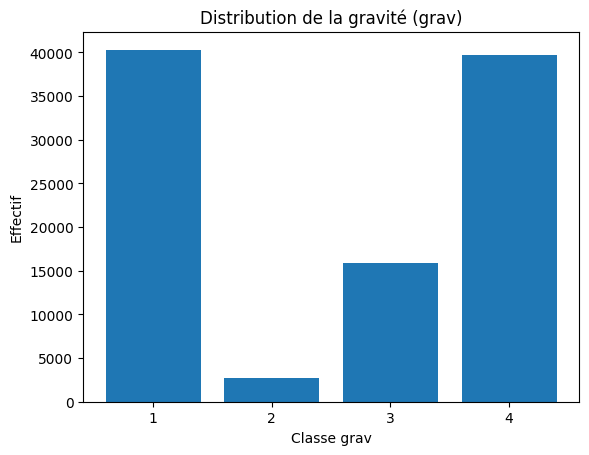

In [45]:
# Distribution de la cible (grav)
if "grav" in df.columns:
    counts = df["grav"].value_counts().sort_index()
    print("Effectifs par classe :")
    print(counts)
    print("\nRépartition (%) :")
    print((counts / counts.sum() * 100).round(2))

    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title("Distribution de la gravité (grav)")
    plt.xlabel("Classe grav")
    plt.ylabel("Effectif")
    plt.show()
else:
    print("Colonne 'grav' absente.")


Variables explorées: ['an_nais', 'sexe', 'catv', 'lum', 'atm', 'obs', 'col', 'agg']


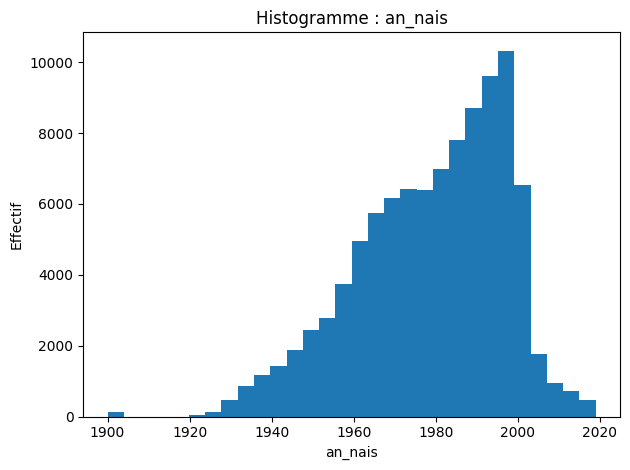

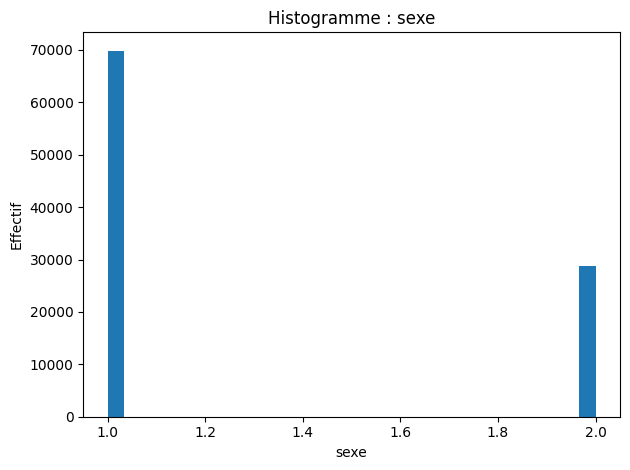

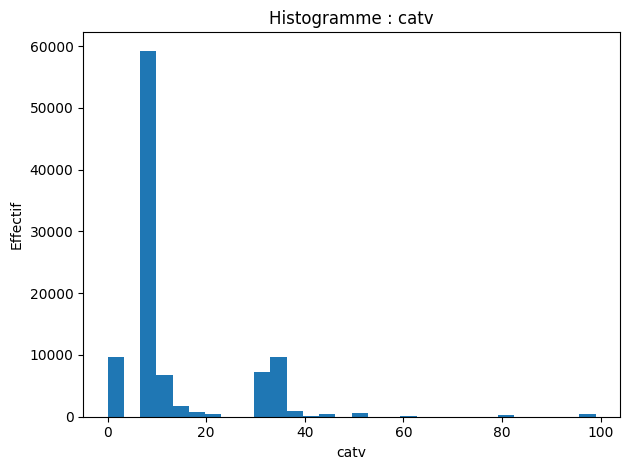

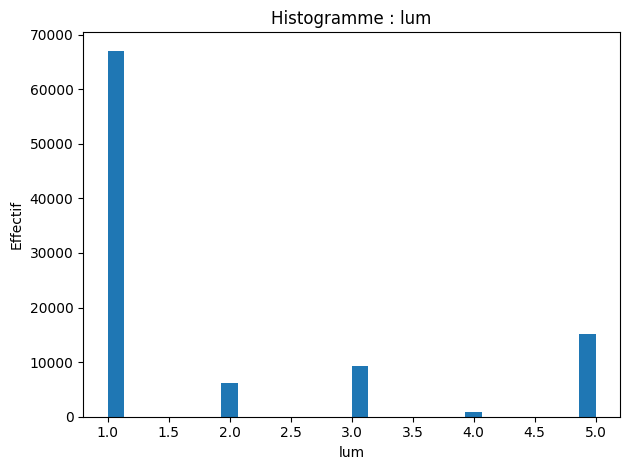

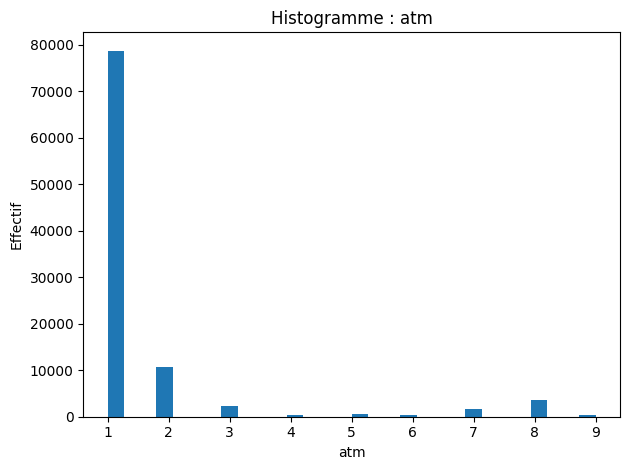

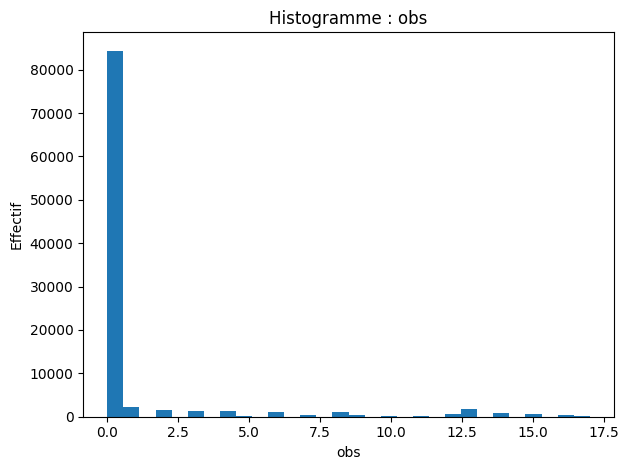

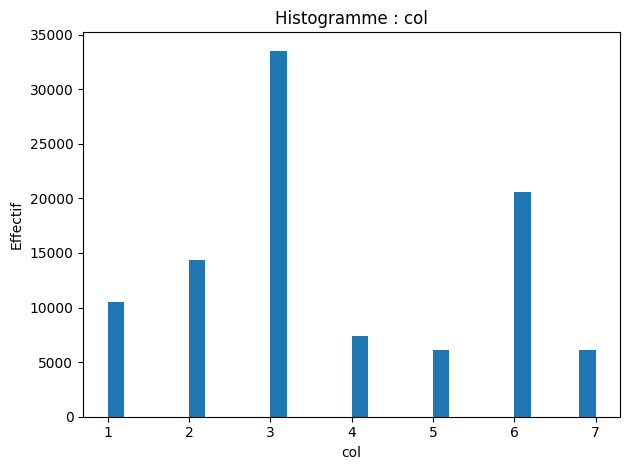

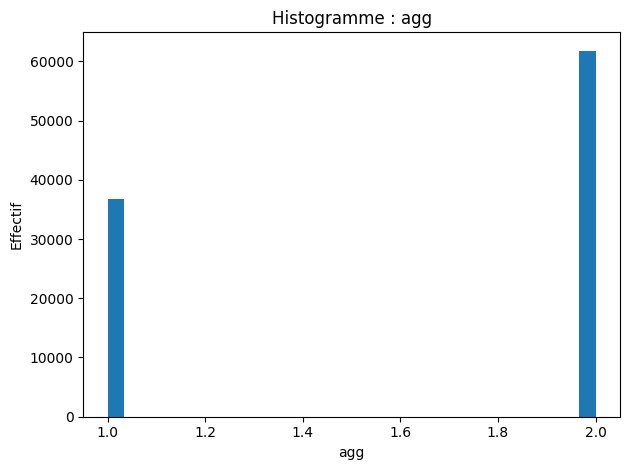

In [46]:
# Distributions d'autres variables qui eux sont explicatives 
candidates = ["an_nais", "sexe", "catv", "lum", "atm", "obs", "col", "agg"]
vars_to_plot = [c for c in candidates if c in df.columns]

print("Variables explorées:", vars_to_plot)

for col in vars_to_plot:
    plt.figure()
    if df[col].dtype == "object":
        vc = df[col].value_counts().head(15)
        plt.bar(vc.index.astype(str), vc.values)
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Distribution (top 15) : {col}")
        plt.xlabel(col)
        plt.ylabel("Effectif")
    else:
        plt.hist(df[col].dropna(), bins=30)
        plt.title(f"Histogramme : {col}")
        plt.xlabel(col)
        plt.ylabel("Effectif")
    plt.tight_layout()
    plt.show()


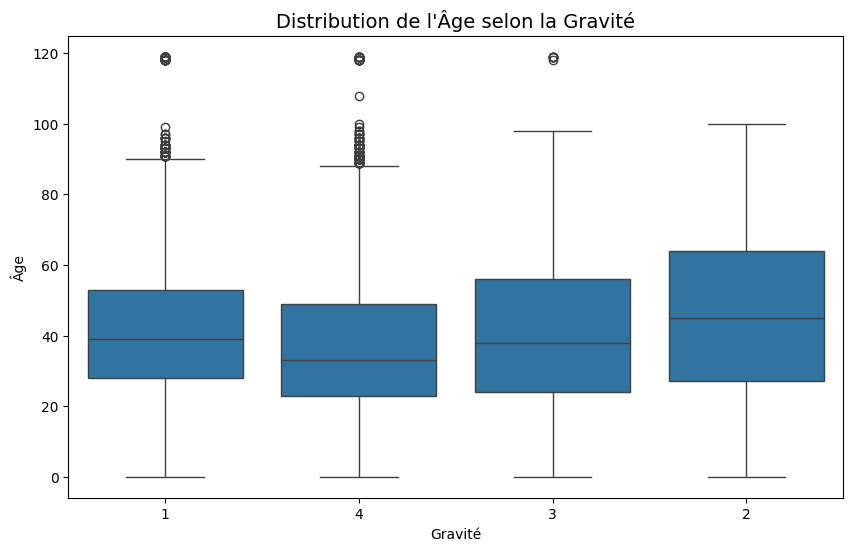

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='grav', y='Age', data=df, order=[1, 4, 3, 2])
plt.title('Distribution de l\'Âge selon la Gravité', fontsize=14)
plt.xlabel('Gravité')
plt.ylabel('Âge')
plt.show()

In [48]:
# Relations avec la cible : tableaux de contingence 
if "grav" in df.columns:
    cat_for_target = [c for c in ["an_nais","sexe", "catv", "lum", "atm", "obs"] if c in df.columns]
    for col in cat_for_target:
        print("\n", col, "vs grav")
        tab = pd.crosstab(df[col], df["grav"], normalize="index") * 100
        display(tab.round(2))



 an_nais vs grav


grav,1,2,3,4
an_nais,,,,
1900,74.74,0.00,6.32,18.95
1901,53.12,0.00,3.12,43.75
1911,0.00,0.00,0.00,100.00
1919,0.00,50.00,0.00,50.00
1920,25.00,50.00,0.00,25.00
...,...,...,...,...
2015,18.29,0.00,13.41,68.29
2016,27.46,1.41,14.08,57.04
2017,41.27,3.17,6.35,49.21



 sexe vs grav


grav,1,2,3,4
sexe,,,,
1,42.28,3.16,17.07,37.48
2,37.45,1.74,13.85,46.97



 catv vs grav


grav,1,2,3,4
catv,,,,
0,13.62,7.98,30.52,47.89
1,4.60,3.72,25.93,65.74
2,4.72,2.91,37.39,54.98
3,45.28,1.79,11.83,41.10
7,51.96,2.45,11.68,33.91
10,62.96,1.81,7.25,27.98
13,74.94,1.27,8.10,15.70
14,78.21,2.44,6.09,13.26
15,79.13,2.49,5.50,12.88



 lum vs grav


grav,1,2,3,4
lum,,,,
1,42.53,2.35,15.53,39.60
2,38.79,2.98,18.52,39.71
3,32.74,7.00,24.27,35.99
4,37.54,3.58,15.02,43.86
5,39.60,1.74,12.83,45.83



 atm vs grav


grav,1,2,3,4
atm,,,,
1.0,41.28,2.66,16.20,39.85
2.0,39.33,2.43,13.82,44.42
3.0,38.93,2.47,16.80,41.80
4.0,45.20,4.55,14.39,35.86
5.0,33.08,5.64,25.00,36.28
6.0,33.33,6.96,27.84,31.87
7.0,42.22,3.98,24.33,29.47
8.0,39.77,3.72,14.40,42.11
9.0,29.23,6.15,22.20,42.42



 obs vs grav


grav,1,2,3,4
obs,,,,
0.0,45.05,1.85,13.56,39.53
1.0,27.67,2.50,17.00,52.83
2.0,6.88,19.49,47.61,26.03
3.0,17.71,6.44,26.56,49.29
4.0,14.67,2.48,18.03,64.82
5.0,14.81,7.41,33.33,44.44
6.0,11.03,12.11,40.09,36.77
7.0,19.74,7.24,32.57,40.46
8.0,13.94,10.83,32.20,43.03


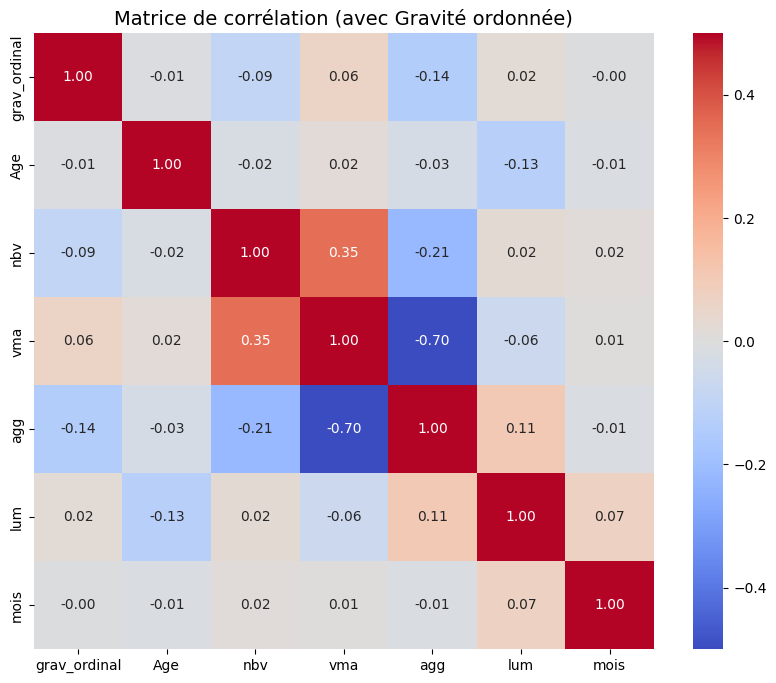

FACTEURS INFLUENÇANT LA GRAVITÉ (grav_ordinal) 
 Positif: Fait augmenter la gravité (vers le Décès).
 Négatif : Fait diminuer la gravité (vers l'Indemne).

vma     0.060638
lum     0.022339
mois   -0.004169
Age    -0.008697
nbv    -0.092093
agg    -0.139775
Name: grav_ordinal, dtype: float64


In [49]:
# On crée une version ordonnée de la gravité pour que la corrélation ait du sens mathématique
# parce que en gros on a une gravité a 1 pour un indemne , a 4 pour un blessé leger , mais a 2 pour un tué , impossible de travailler la dessus
map_gravite = {1: 1, 4: 2, 3: 3, 2: 4}
df['grav_ordinal'] = df['grav'].map(map_gravite)

# Sélection des variables numériques pertinentes pour l'analyse
# On inclut la nouvelle variable cible 'grav_ordinal'
num_cols = ['grav_ordinal', 'Age', 'nbv', 'vma', 'agg', 'lum', 'mois', 'Heure']

# on ne garde que les colonnes qui existent vraiment dans le dataframe
existing_cols = [c for c in num_cols if c in df.columns]
df_corr = df[existing_cols].dropna()

# CALCUL

if len(existing_cols) > 1:
    # Calcul de la matrice de corrélation
    corr_matrix = df_corr.corr()

    # Affichage graphique 
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-0.5, vmax=0.5)
    plt.title("Matrice de corrélation (avec Gravité ordonnée)", fontsize=14)
    plt.show()

    # AFFICHAGE DU TOP DES CORRÉLATIONS 
    target = 'grav_ordinal'
    
    if target in corr_matrix.columns:
        print(f"FACTEURS INFLUENÇANT LA GRAVITÉ ({target}) ")
        print(" Positif: Fait augmenter la gravité (vers le Décès).")
        print(" Négatif : Fait diminuer la gravité (vers l'Indemne).\n")
        
        # On trie par valeur absolue pour voir les influences les plus fortes (positives ou négatives)
        correlations = corr_matrix[target].drop(target) # On enlève la corrélation avec elle-même
        print(correlations.sort_values(ascending=False))

## Conclusion
On voit que la Vitesse maximale autorisé et la luminosité sont des facteurs aggravants.
    

# Étape 4 — Préparation et séparation des données

Objectifs :
- définir `X` et `y`
- encodage simple  des variables catégorielles avec `pd.factorize`
- split train/test 

> Pour la classification, on conserve la distribution de la cible via `stratify=y`.


In [50]:
from sklearn.model_selection import train_test_split


In [51]:
##On drop les colones grav_ordinal et age car on en avait pas besoin , et bien sur grav car c'est la prédicition
cols_to_drop = ["grav", "grav_ordinal", "Age"]

# Séparation X / y
y = df["grav"]
X = df.drop(columns=cols_to_drop)
print("X:", X.shape, "y:", y.shape)
# Préparation / encodage 
X_enc = X.copy()


# Supprimer colonnes datetime 
dt_cols = X_enc.select_dtypes(include=["datetime64[ns]", "datetime64"]).columns.tolist()
if len(dt_cols) > 0:
    X_enc = X_enc.drop(columns=dt_cols)

# Encodage object vers codes entiers
for col in X_enc.columns:
    if X_enc[col].dtype == "object":
        X_enc[col] = X_enc[col].fillna("Inconnue")
        X_enc[col] = pd.factorize(X_enc[col])[0]

# Supprimer colonnes 100% NaN au cas ou
cols_all_nan = X_enc.columns[X_enc.isna().all()].tolist()
if len(cols_all_nan) > 0:
    X_enc = X_enc.drop(columns=cols_all_nan)

# Imputation numérique vers médiane
for col in X_enc.columns:
    if X_enc[col].isna().sum() > 0:
        X_enc[col] = X_enc[col].fillna(X_enc[col].median())

print("NaN final :", int(X_enc.isna().sum().sum()))
print("Colonnes non numériques :", X_enc.select_dtypes(exclude=[np.number]).columns.tolist())

display(X_enc.head())


X: (98618, 57) y: (98618,)
NaN final : 0
Colonnes non numériques : []


,num_acc,id_vehicule_x,num_veh,place,catu,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp,id_vehicule_y,senc,catv,obs,obsm,choc,manv,motor,occutc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long,heure,minute,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,201900000001,0,0,2,2,2,2002,0.0,1.0,0.0,9.0,0.0,-1.0,1.0,0,2.0,7,0.0,2.0,5.0,23.0,1.0,1.0,30.0,11.0,2019,0,4,93.0,93053.0,1,1,1.0,2.0,0,48.896210,2.470120,1.0,30.0,1,0,0.0,0,3.0,10.0,0.0,1.0,6.0,900.0,2.0,0.0,14.0,1.0,2.0,1.0,70.0
1,201900000001,1,1,1,1,1,1959,0.0,1.0,0.0,9.0,0.0,-1.0,1.0,1,2.0,17,1.0,0.0,3.0,11.0,1.0,1.0,30.0,11.0,2019,0,4,93.0,93053.0,1,1,1.0,2.0,0,48.896210,2.470120,1.0,30.0,1,0,0.0,0,3.0,10.0,0.0,1.0,6.0,900.0,2.0,0.0,14.0,1.0,2.0,1.0,70.0
2,201900000002,2,1,1,1,2,1994,0.0,1.0,0.0,9.0,0.0,-1.0,1.0,2,1.0,7,4.0,0.0,1.0,0.0,1.0,1.0,30.0,11.0,2019,1,3,93.0,93066.0,1,1,1.0,6.0,1,48.930700,2.368800,2.0,50.0,1,1,0.0,0,1.0,2.0,0.0,4.0,3.0,845.0,2.0,0.0,14.0,1.0,0.0,1.0,70.0
3,201900000003,3,1,1,1,1,1996,0.0,1.0,0.0,9.0,0.0,0.0,1.0,3,1.0,7,0.0,2.0,1.0,2.0,1.0,1.0,28.0,11.0,2019,2,1,92.0,92036.0,1,1,1.0,4.0,2,48.935872,2.319174,15.0,15.0,1,2,0.0,0,3.0,8.0,0.0,1.0,10.0,500.0,3.0,0.0,14.0,1.0,0.0,1.0,90.0
4,201900000003,4,0,1,1,1,1995,9.0,1.0,0.0,9.0,0.0,0.0,1.0,4,1.0,7,1.0,0.0,4.0,2.0,1.0,1.0,28.0,11.0,2019,2,1,92.0,92036.0,1,1,1.0,4.0,2,48.935872,2.319174,15.0,15.0,1,2,0.0,0,3.0,8.0,0.0,1.0,10.0,500.0,3.0,0.0,14.0,1.0,0.0,1.0,90.0


In [52]:
# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (78894, 56) (78894,)
Test : (19724, 56) (19724,)


# Modélisation 


In [53]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


## Rappel des données préparées 

On suppose que les variables suivantes existent :
- `X_train`, `X_test`
- `y_train`, `y_test`


In [54]:
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

print("Classes de la cible :", np.unique(y_train))


X_train: (78894, 56)
X_test : (19724, 56)
y_train: (78894,)
y_test : (19724,)
Classes de la cible : [1 2 3 4]


## Modèle 1 — Régression Logistique

- Modèle linéaire
- Sert de **baseline**
- Interprétable


In [55]:
# Initialisation du modèle
log_reg = LogisticRegression(max_iter=1000)

# Entrainement
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)

print("Régression Logistique entraînée.")


Régression Logistique entraînée.


## Modèle 2 — Arbre de décision

- Modèle non linéaire
- Capte des interactions
- Facile à interpréter


In [56]:
# Initialisation du modele
tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=50,
    random_state=42
)

# Entrainement
tree.fit(X_train, y_train)

# Prédictions
y_pred_tree = tree.predict(X_test)

print("Arbre de décision entraîné.")


Arbre de décision entraîné.


Modèle 3 : RANDOM FOREST


In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"   # classe desiquilibré (mort a 2%) donc on met ça
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest entraîné.")


Random Forest entraîné.


# Étape 6 — Évaluation des modèles 


Métriques expliquées:
- Accuracy
- F1-score
- Matrice de confusion


In [58]:
# Évaluation Régression Logistique
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")

print("=== Régression Logistique ===")
print("Accuracy :", round(acc_lr, 4))
print("F1-score :", round(f1_lr, 4))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_lr))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_lr,zero_division=0))


=== Régression Logistique ===
Accuracy : 0.4087
F1-score : 0.2371
Matrice de confusion :
[[8061    0    0    0]
 [ 542    0    0    0]
 [3182    0    0    0]
 [7939    0    0    0]]

Rapport de classification :
              precision    recall  f1-score   support

           1       0.41      1.00      0.58      8061
           2       0.00      0.00      0.00       542
           3       0.00      0.00      0.00      3182
           4       0.00      0.00      0.00      7939

    accuracy                           0.41     19724
   macro avg       0.10      0.25      0.15     19724
weighted avg       0.17      0.41      0.24     19724



In [59]:
# Évaluation Arbre de Décision
acc_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree, average="weighted")

print("=== Arbre de Décision ===")
print("Accuracy :", round(acc_tree, 4))
print("F1-score :", round(f1_tree, 4))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_tree))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_tree))


=== Arbre de Décision ===
Accuracy : 0.6663
F1-score : 0.6518
Matrice de confusion :
[[6848    3  166 1044]
 [  80   15  283  164]
 [ 410   27 1406 1339]
 [2194    8  864 4873]]

Rapport de classification :
              precision    recall  f1-score   support

           1       0.72      0.85      0.78      8061
           2       0.28      0.03      0.05       542
           3       0.52      0.44      0.48      3182
           4       0.66      0.61      0.63      7939

    accuracy                           0.67     19724
   macro avg       0.54      0.48      0.48     19724
weighted avg       0.65      0.67      0.65     19724



In [60]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")

print("=== Random Forest ===")
print("Accuracy :", round(acc_rf, 4))
print("F1-score :", round(f1_rf, 4))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_rf, zero_division=0))


=== Random Forest ===
Accuracy : 0.6779
F1-score : 0.6606
Matrice de confusion :
[[6874    1  161 1025]
 [  72   12  301  157]
 [ 472    7 1261 1442]
 [2147    1  568 5223]]

Rapport de classification :
              precision    recall  f1-score   support

           1       0.72      0.85      0.78      8061
           2       0.57      0.02      0.04       542
           3       0.55      0.40      0.46      3182
           4       0.67      0.66      0.66      7939

    accuracy                           0.68     19724
   macro avg       0.63      0.48      0.49     19724
weighted avg       0.67      0.68      0.66     19724



## Comparaison des modèles

| Modèle | Accuracy | F1-score |
|------|----------|----------|
| Régression Logistique | 0,41 | 0,24 |
| Arbre de Décision | 0,66 | 0,65 |
| Random Forest | 0,67 | 0.66|


INTERPRETATION:


In [61]:
# Importance des variables (Random Forest)
importances = rf.feature_importances_

feat_importance = pd.Series(importances, index=X_train.columns)
feat_importance = feat_importance.sort_values(ascending=False)

print("Top 15 variables les plus importantes :")
display(feat_importance.head(15))


Top 15 variables les plus importantes :


secu1            0.048693
an_nais          0.046913
lat              0.044045
long             0.040430
catv             0.040363
com              0.039731
adr              0.036956
hrmn             0.035908
voie             0.035094
id_vehicule_x    0.033320
id_vehicule_y    0.032979
dep              0.030038
heure            0.029578
jour             0.029564
col              0.029286
dtype: float64

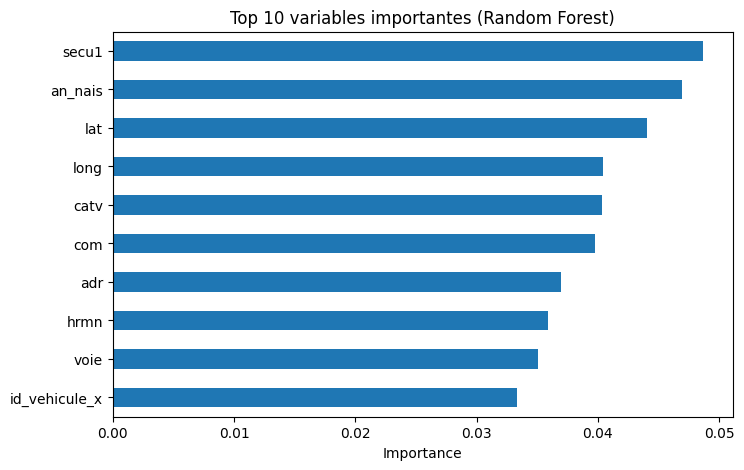

In [62]:
plt.figure(figsize=(8,5))
feat_importance.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 variables importantes (Random Forest)")
plt.xlabel("Importance")
plt.show()


## Conclusion 

On voit que la ceinture de sécurité , ainsi que l'age sont les variables les plus importantes lorsque l'on veut evaluer la gravité de l'accident


In [63]:
results = pd.DataFrame({
    "Modèle": ["Régression logistique", "Arbre de décision", "Random Forest"],
    "Accuracy": [acc_lr, acc_tree, acc_rf],
    "F1-score pondéré": [f1_lr, f1_tree, f1_rf]
})

results


,Modèle,Accuracy,F1-score pondéré
0,Régression logistique,0.408690,0.237139
1,Arbre de décision,0.666295,0.651832
2,Random Forest,0.677854,0.660631


## ANALYSE DES ERREURS


In [64]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)
print("Matrice de confusion :")
print(cm)


Matrice de confusion :
[[6874    1  161 1025]
 [  72   12  301  157]
 [ 472    7 1261 1442]
 [2147    1  568 5223]]


# Étape 7. Analyse des Résultats 

Suite à l'entraînement de notre modèle de Random Forest, nous avons généré la matrice de confusion sur le jeu de test pour évaluer la qualité des prédictions par classe. Voici notre analyse des résultats :

### 1. Constat général
La matrice met en évidence une performance très inégale selon la gravité de l'accident. Le modèle réussit bien à identifier les situations les plus fréquentes, mais échoue sur les cas les plus critiques.

* **Bonne détection des cas "bénins" :** La grande majorité des usagers **Indemnes (Classe 1)** et **Blessés Légers (Classe 4)** sont correctement classés (valeurs élevées sur la diagonale). Cela s'explique par le fait que ces deux classes représentent près de 80% du dataset.
* **Échec sur la classe "Tué" (Classe 2) :** C'est le point faible majeur du modèle actuel. Sur **542 décès réels** présents dans notre jeu de test, le modèle n'en a prédit correctement que **12**, soit un taux de détection (Rappel/Recall) d'environ **2.2%**.

### 2. Analyse des erreurs (Confusion)
En regardant les erreurs de prédiction pour la classe "Tué" (Ligne 2 de la matrice), nous observons que :
* **301 décès** ont été prédits à tort comme "Hospitalisés" (Classe 3).
* **157 décès** ont été prédits comme "Blessés Légers" (Classe 4).

**Interprétation :** Ce phénomène est dû au fort **déséquilibre des classes**. Comme les décès sont très rares (~2.6% des données), le modèle a "appris" statistiquement qu'il est moins risqué de prédire une blessure (Hospitalisé ou Léger) plutôt qu'un décès pour maximiser son score d'Accuracy. De plus, la frontière entre un blessé grave hospitalisé et un décès tient souvent à des facteurs médicaux ou de fragilité (âge) que le modèle peine à séparer nettement avec les variables actuelles.
